In [1]:
import os
import cv2
import h5py
import numpy
import prepare_data as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, add, Activation, UpSampling2D, concatenate, Conv2DTranspose

In [2]:
#TRAINING DATA PREPARATION
DATA_PATH = "yang91/" #
Random_Crop = 10
Patch_size = 100
label_size = 200
scale = 2


def prepare_training_data():
    names = os.listdir(DATA_PATH)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = DATA_PATH + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # produce Random_Crop random coordinate to crop training img
        if(min(shape[0], shape[1]) - label_size < 0):
            continue
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - label_size, Random_Crop)

        for j in range(Random_Crop):
            hr_patch = hr_img[Points_x[j]: Points_x[j] + label_size, Points_y[j]: Points_y[j] + label_size]
            lr_patch = cv2.resize(hr_patch, (label_size // scale, label_size // scale), cv2.INTER_CUBIC)

            lr_patch = lr_patch.astype(float) // 255.
            hr_patch = hr_patch.astype(float) // 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label


def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label


if __name__ == "__main__":
    data, label = prepare_training_data()
    write_hdf5(data, label, "WAZIR_TRAINING_FILE.h5")
    # _, _a = read_training_data("train.h5")
    # _, _a = read_training_data("test.h5")

In [3]:
def UP():
    _input = Input(shape=(None, None, 1))
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',name='C_1')(_input)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_2')(_input)
    out = add(inputs=[conv1,conv2])
    out = Activation('relu')(out)
    #conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_3')(out)
    out1 = add(inputs=[_input,out])
    #out1 = concatenate(inputs=[_input,out])
    U1 = UpSampling2D((2,2), input_shape=(None, None, 1), interpolation='bilinear')(out1)
    model1 = Model(inputs=_input, outputs=U1)

    return model1
    

In [4]:
UPSAMPLE = UP()

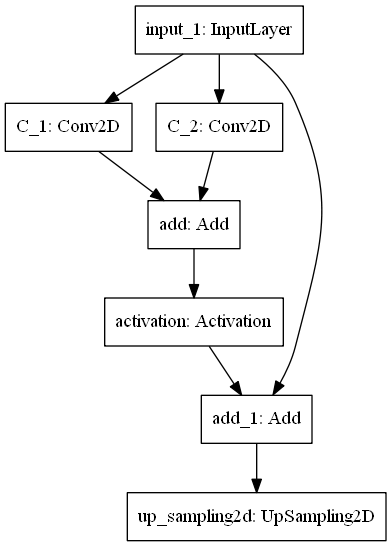

In [5]:
import tensorflow as tf
tf.keras.utils.plot_model(UPSAMPLE , 'RESNET_BLOCK.png')

In [6]:
def Res_block():
    _input = Input(shape=(None, None, 64))

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',name='C_1')(_input)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_2')(_input)

    out = add(inputs=[conv1,conv2])
    out = Activation('relu')(out)
    #conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_3')(out)
    out1 = add(inputs=[_input,out])
    #out1 = concatenate(inputs=[_input,out])

    model = Model(inputs=_input, outputs=out1)

    return model

In [7]:
RESNET_BLOCK = Res_block()

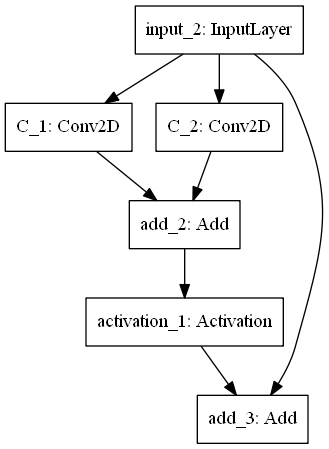

In [8]:
import tensorflow as tf
tf.keras.utils.plot_model(RESNET_BLOCK , 'RESNET_BLOCK.png')

In [9]:
def model_WAZIR():
    _input = Input(shape=(None, None, 1), name='INPUT_LR_IMAGE')
    
    #FIRST THREE LAYER IS USED TO EXTRACT THE FEATURES
    C1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',name='FIRST_LAYER')(_input)
    C2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu',name='SECOND_LAYER')(C1)
    C3 = Conv2D(filters=64, kernel_size=(3,3), strides=(1, 1), padding='same', activation='relu',name='THIRD_LAYER')(C2)
    
    
    #UPSAMPLING LAYER
    #U = Conv2DTranspose(filters=4, kernel_size=(14, 14), strides=(scale,scale),padding='same', activation='relu',name='UPSCALE_LAYER')(C1)
    #RESNET BLOCK
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu',name='C_1')(C3)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_2')(C3)
    out = add(inputs=[conv1,conv2])
    out1 = Activation('relu')(out)
    #conv3 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='linear',name='C_3')(out)
    out2 = add(inputs=[C3,out1])

    # ****BLOCK1***********
    MAIN_NODE_1 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='MAIN_NODE_1')(out2)
    
    
    Branch1a = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1a')(MAIN_NODE_1)
    Branch1b = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1b')(MAIN_NODE_1)
    Branch1c = Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1),padding='same', activation='relu',name='BRANCH_1c')(MAIN_NODE_1)
    
    
    # ****CONCATENATION NODE***********
    Concatenate1 = concatenate(inputs=[Branch1a, Branch1b, Branch1c])
    out1 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='OUTPUT_LAYER_1')(Concatenate1)
    
    
    # ****BLOCK2***********
    MAIN_NODE_2 = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu',name='MAIN_NODE_2')(out1)
    
    
    Branch2a = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2a')(MAIN_NODE_2)
    Branch2b = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2b')(MAIN_NODE_2)
    Branch2c = Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1),padding='same', activation='relu',name='BRANCH_2c')(MAIN_NODE_2)
    
    
    # ****CONCATENATION NODE***********
    Concatenate2 = concatenate(inputs=[Branch2a, Branch2b, Branch2c])
    out2 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu',name='OUTPUT_LAYER_2')(Concatenate2)
    U1 = UP()(_input)
    U2 = Conv2DTranspose(filters=1, kernel_size=(14, 14), strides=(scale,scale),padding='same', activation='relu',name='UPSCALE_LAYER')(out2)
    U3 = UP()(_input)
    Concatenate3 = concatenate(inputs=[U1,U2,U3])
    out32 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1,1), padding='same', activation='relu',name='OUTPUT_LAYER_33')(Concatenate3)
  

        
    model = Model(_input, out32)

    return model

In [10]:
WAZIR = model_WAZIR()

In [11]:
WAZIR.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT_LR_IMAGE (InputLayer)     [(None, None, None,  0                                            
__________________________________________________________________________________________________
FIRST_LAYER (Conv2D)            (None, None, None, 6 640         INPUT_LR_IMAGE[0][0]             
__________________________________________________________________________________________________
SECOND_LAYER (Conv2D)           (None, None, None, 6 36928       FIRST_LAYER[0][0]                
__________________________________________________________________________________________________
THIRD_LAYER (Conv2D)            (None, None, None, 6 36928       SECOND_LAYER[0][0]               
____________________________________________________________________________________________

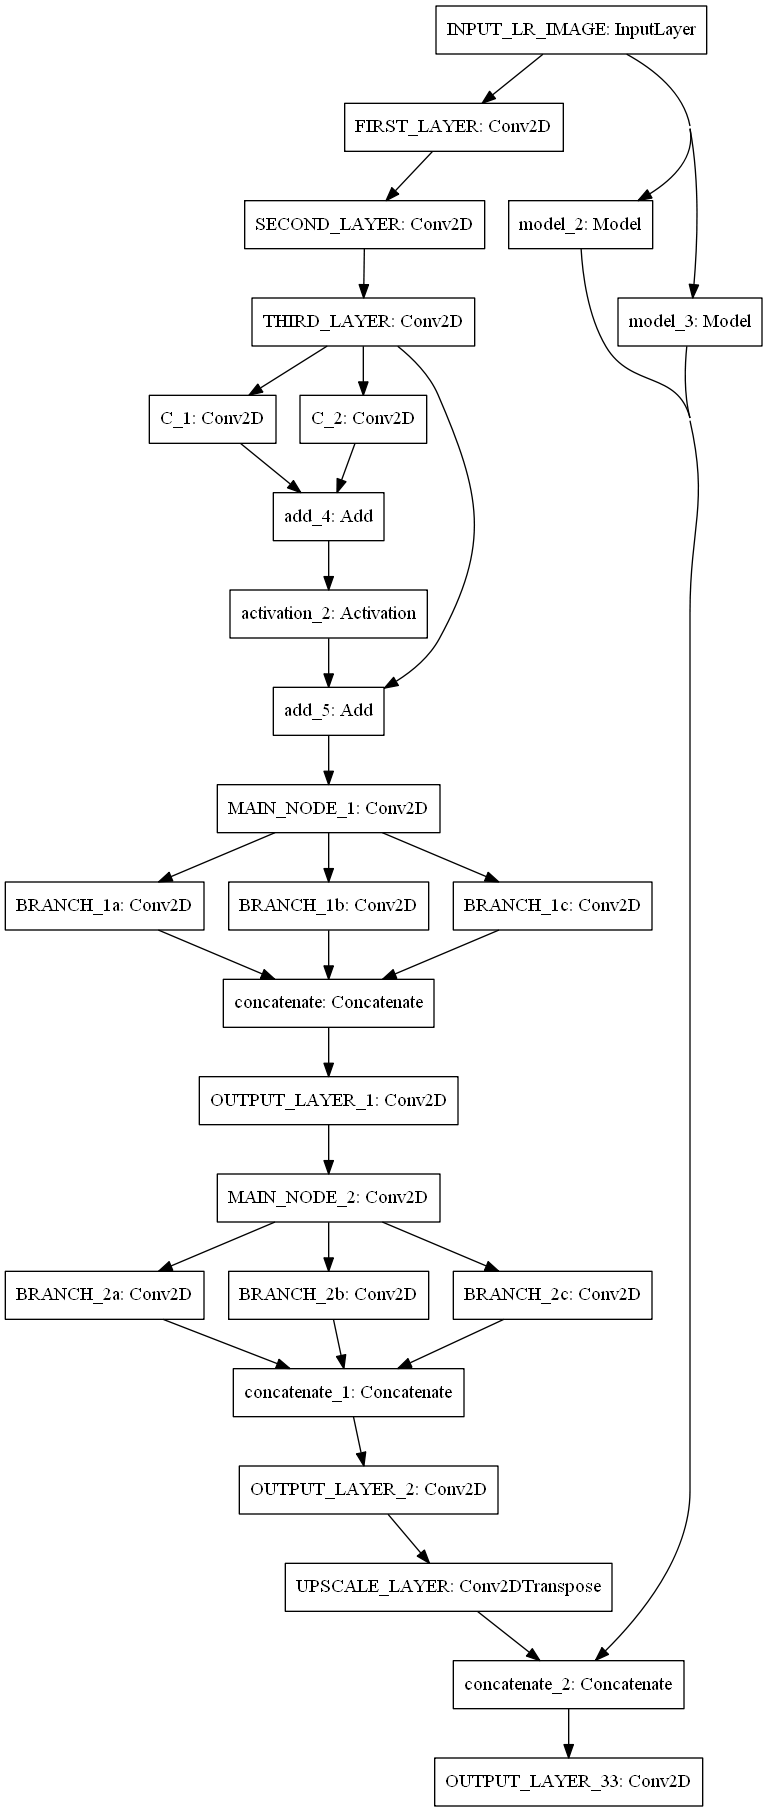

In [12]:
import tensorflow as tf
tf.keras.utils.plot_model(WAZIR, 'PKONT_PROPOSED_MODEL.png')

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop

In [21]:
#IF YOU START TRAINING THAN REMOVE # SYMBOL
def WAZIR_train():
    WAZIR = model_WAZIR()
    WAZIR.compile(loss='mse',optimizer='RMSprop', metrics=["accuracy"])
    checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor
    data, label = pd.read_training_data("WAZIR_TRAINING_FILE.h5")
    WAZIR.fit(data, label, batch_size=32, epochs=1,callbacks=[checkpoint],verbose=1,workers = 8)
    WAZIR.save_weights("WAZIR_MODEL_SCALE_2X.h5")
if __name__ == "__main__":
    WAZIR_train()

Train on 8000 samples
8000/8000 [==============================] - 54s 7ms/sample - loss: 6.4356e-04 - accuracy: 0.9993


In [22]:
def WAZIR_predict():
    WAZIR = model_WAZIR()
    WAZIR.load_weights("WAZIR_MODEL_SCALE_2X.h5")
    IMG_NAME = "baby_GT.bmp"
    INPUT_NAME = "INPUT_LOW_RESOLUTION_IMAGE.png"
    OUTPUT_NAME = "MODEL_OUTPUT_IMAGE.png"
    
    
    
    import cv2
    img = cv2.imread(IMG_NAME)
    shape = img.shape
    img = cv2.resize(img, (shape[1] // scale, shape[0] // scale), cv2.INTER_CUBIC)
    cv2.imwrite(INPUT_NAME, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1))
    Y[0, :, :, 0] = img[:, :, 0]
    img = cv2.resize(img, (shape[1], shape[0]), cv2.INTER_CUBIC)

    pre = WAZIR.predict(Y, batch_size=1)
    pre[pre[:] > 255] = 255
    pre = pre.astype(numpy.uint8)
    img[:, :, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)
    
    im2 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)

    
    print ("WAZIR_MODEL:")
    print (cv2.PSNR(im1, im2))


if __name__ == "__main__":
    WAZIR_predict()

WAZIR_MODEL:
38.10101413614615


In [16]:
#PSNR = 38.5164760667307, BATCH=32, EPOCH = 2

In [ ]:
#img2 = cv2.imread('INPUT_LOW_RESOLUTION_IMAGE.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('2X_LRIMAGE',img2)


#img4 = cv2.imread('MODEL_OUTPUT_IMAGE.png', cv2.IMREAD_UNCHANGED)
#cv2.imshow('WAZIR_OUTPUT_MODEL_IMAGE',img4)

#cv2.waitKey(0) #image will not show until this is called
#cv2.destroyAllWindows() #make sure window closes cleanly